In [4]:
from GNEMS import *

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Comparisons

### Noise Tolerance

In [2]:
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.future import graph
import networkx
import skimage
print(skimage.__version__)
print(networkx.__version__)

0.19.3
2.8.8


In [64]:
f1_scores = {
    "GNEMS": [],
    "k-means": [],
    "Otsu": [],
    "nCuts": []
}
segmentations = {
    "GNEMS": [],
    "k-means": [],
    "Otsu": [],
    "nCuts": []
}
noise_levels = np.logspace(-4, 4, 16, base=2)
for noise_level in noise_levels:
    print("Testing noise level", noise_level, "...")
    image, pixelwise_labels = generate_image(size=(512, 512), noise=noise_level, seed=2)
    image += image.min()
    image /= image.max()

    segmentor = GraphicallyGuidedEMSegmentor(
                d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=200, subset_size=0.5, prediction_stride=16,
                seed=2
            )
    segmentor.fit(image)
    segmentation = segmentor.predict()
    accuracy, report, conf_matrix = evaluate(pixelwise_labels, segmentation, plot=False)
    segmentations["GNEMS"].append(segmentation)
    f1_scores["GNEMS"].append(report["weighted avg"]["f1-score"])

    segmentor = KMeans(n_clusters=2, random_state=2)
    segmentor.fit(image.reshape(-1, 1))
    segmentation = segmentor.labels_.reshape(image.shape)
    accuracy, report, conf_matrix = evaluate(pixelwise_labels, segmentation, plot=False)
    segmentations["k-means"].append(segmentation)
    f1_scores["k-means"].append(report["weighted avg"]["f1-score"])

    high_image = np.stack([image, image, image], axis=-1) * 255
    superpixels = slic(high_image, compactness=30, n_segments=400)
    g = graph.rag_mean_color(high_image, superpixels, mode='similarity')
    segmentation = np.zeros_like(image)
    tries = 0
    while(len(np.unique(segmentation)) < 2 and tries < 10):
        segmentation = graph.cut_normalized(superpixels, g, num_cuts=2)
        tries += 1
    t = auto_threshold(segmentation)
    segmentation = (segmentation < t).astype(int)
    accuracy, report, conf_matrix = evaluate(pixelwise_labels, segmentation, plot=False)
    segmentations["nCuts"].append(segmentation)
    f1_scores["nCuts"].append(report["weighted avg"]["f1-score"])

    t = skimage.filters.threshold_otsu(image.reshape(-1, 1))
    segmentation = image > t
    accuracy, report, conf_matrix = evaluate(pixelwise_labels, segmentation, plot=False)
    segmentations["Otsu"].append(segmentation)
    f1_scores["Otsu"].append(report["weighted avg"]["f1-score"])

Testing noise level 0.0625 ...


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Testing noise level 0.09045432734002362 ...


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


Testing noise level 0.1309117653525783 ...


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


Testing noise level 0.18946457081379978 ...


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


Testing noise level 0.2742062449236565 ...


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


Testing noise level 0.39685026299204984 ...


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Testing noise level 0.5743491774985175 ...


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Testing noise level 0.8312378961427878 ...


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


Testing noise level 1.2030250360821166 ...


100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Testing noise level 1.741101126592248 ...


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Testing noise level 2.519842099789746 ...


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

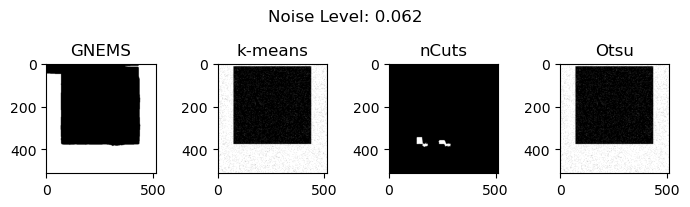

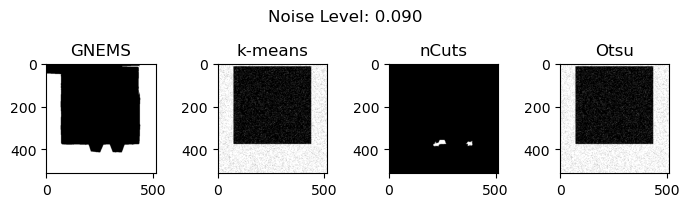

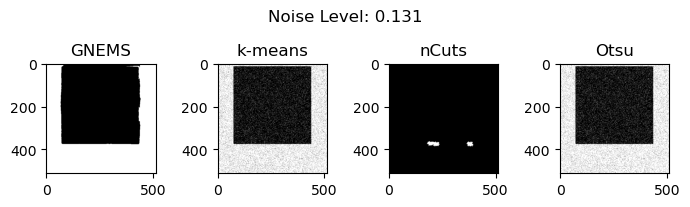

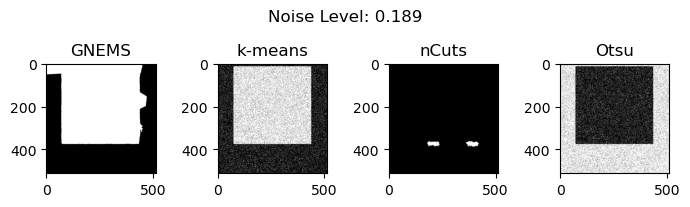

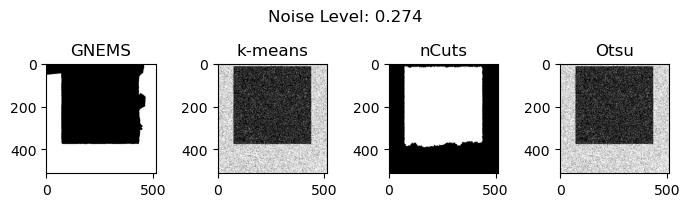

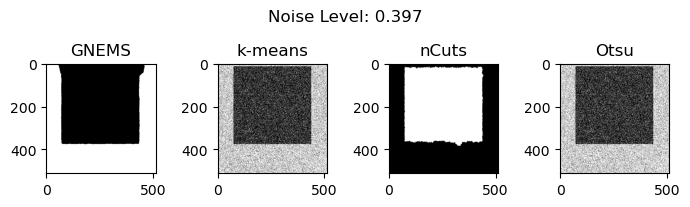

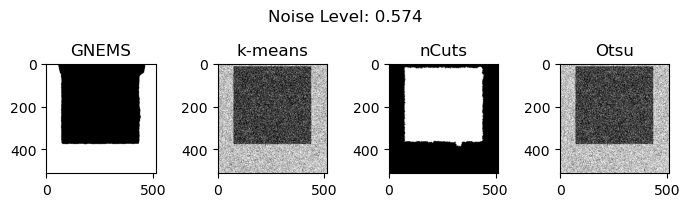

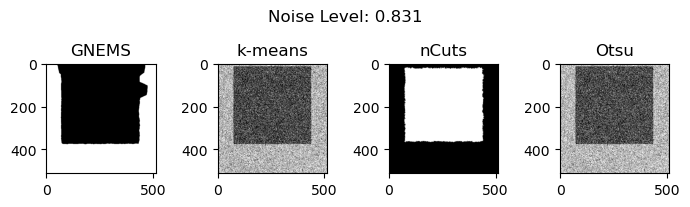

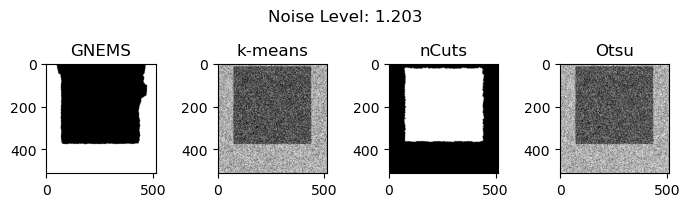

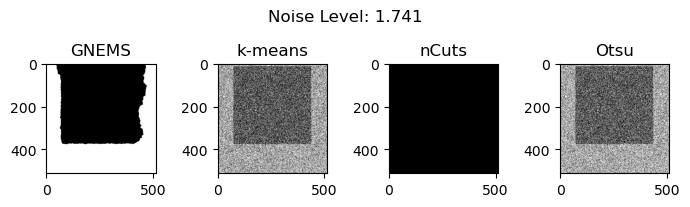

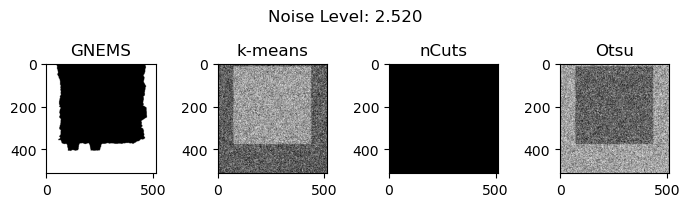

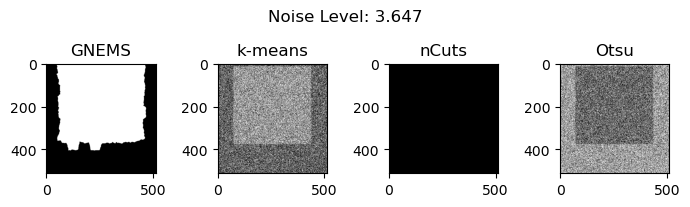

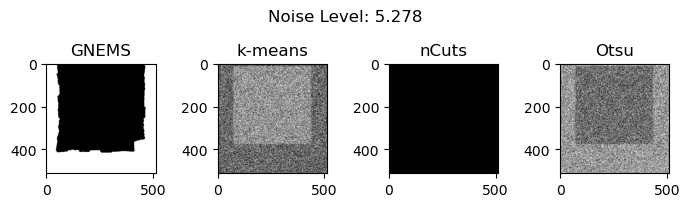

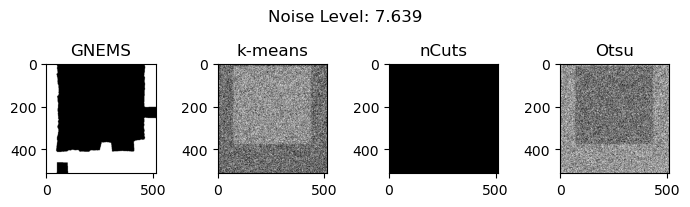

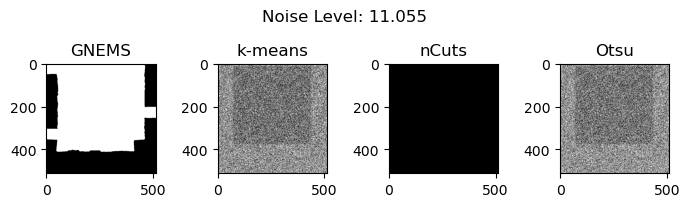

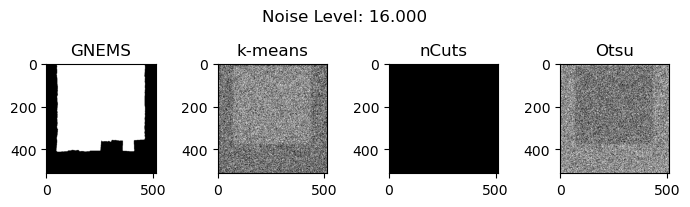

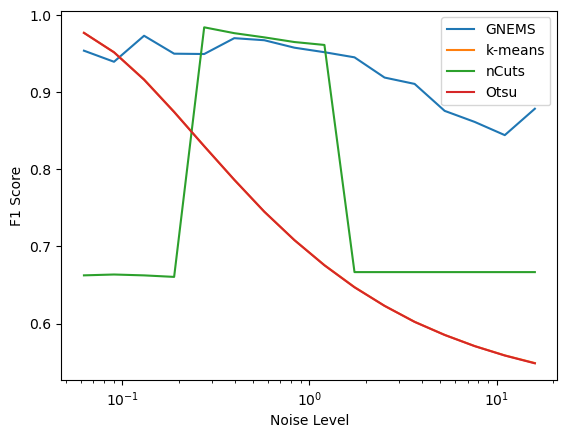

In [ ]:
for i,noise_level in enumerate(noise_levels):
    fig, axs = plt.subplots(1, 4, figsize=(7, 2))
    axs[0].imshow(segmentations["GNEMS"][i], cmap="gray")
    axs[0].set_title("GNEMS")
    axs[1].imshow(segmentations["k-means"][i], cmap="gray")
    axs[1].set_title("k-means")
    axs[2].imshow(segmentations["nCuts"][i], cmap="gray")
    axs[2].set_title("nCuts")
    axs[3].imshow(segmentations["Otsu"][i], cmap="gray")
    axs[3].set_title("Otsu")
    plt.suptitle(f'Noise Level: {noise_level:.3f}')
    plt.tight_layout()
    plt.show()

plt.plot(noise_levels, f1_scores["GNEMS"], label="GNEMS")
plt.plot(noise_levels, f1_scores["k-means"], label="k-means")
plt.plot(noise_levels, f1_scores["nCuts"], label="nCuts")
plt.plot(noise_levels, f1_scores["Otsu"], label="Otsu")
plt.xscale("log")
plt.xlabel("Noise Level")
plt.ylabel("F1 Score")
plt.legend()
plt.show()
